## Change Log (v.4)
- Stateful LSTM
- Dropout to 0.01

# 1. Import

In [97]:
%load_ext autoreload
%autoreload
# -*- coding: utf-8 -*-
'''
    An implementation of sequence to sequence learning
    for performing ensemble morphosyntactic analyses
'''
from __future__ import print_function
# from keras.preprocessing.sequence import pad_sequences
import numpy as np
from six.moves import range
from prepare_data import SawarefData, padIndexes
from character_table import colors, CharacterTable, eprint
import pandas as pd
import itertools
import re
from ws_client import WebSocketClient
import pickle
import sys
import datetime
from keras.callbacks import TensorBoard
from buckwalter import utf2bw, bw2utf
from pprint import pprint

# do not import in interactive mode
# from vis import SawarefVis
from keras.models import Sequential, Model, load_model
from keras import layers
from keras.callbacks import EarlyStopping, Callback
from keras.utils import plot_model


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 2. Constants

In [98]:
try:
    writer_all
except NameError:
    writer_all = pd.ExcelWriter('all_results.xlsx')

In [100]:
class Experiment:
    feat_x = [
        "MXpos", "STpos", "AMpos", "FApos", 
        "STaspect", "AMaspect", "MXaspect", "FAaspect", 
        "STperson", "AMperson", "MXperson", "FAperson", 
        "STgender", "AMgender", "MXgender", "FAgender", 
        "STnumber", "AMnumber", "MXnumber", "FAnumber", 
        "STcase", "AMcase", "MXcase", "FAcase", 
        "STvoice", "AMvoice", "MXvoice", "FAvoice", 
        "STmood", "AMmood", "MXmood", "FAmood", 
        "STstate", "AMstate", "MXstate", "FAstate"
    ]
    feat_y = [
        "QApos", "QAaspect", "QAperson", "QAgender", "QAnumber", "QAcase",
        "QAvoice", "QAmood", "QAstate"
    ]
    strings_x = ["STwutf8"]
    strings_y = ["QAutf8"]
    MYPATH = "/morpho/output/"
    # Parameters for the model and dataset.
    TRAINING_SIZE = 50000
    EPOCHS = 100
    EMBEDDINGS = 0
    # DIGITS = 3
    # REVERSE = True
    # Try replacing GRU, or SimpleRNN.
    HIDDEN_SIZE = 128
    BATCH_SIZE = 64
    LAYERS = 1
    ITERATIONS = 10
    REVERSE = False
    MODEL_NAME = "main-seq-multiinput-multioutput-segmentation.keras"
    DATA_PICKLE = "main-seq-multiinput-multioutput-segmentation.pickle"
    RNN = layers.LSTM
    CATS_EMBEDDING = 1000
    TEST_SPLIT = 1  #  means 0.1 of data is for test
    VAL_SPLIT = 1  #  means 0.1 of data is for test
    LOAD_FASTTEXT = False
    CHARACTER_BASED = False
    MORPHEME_BASED = False
    previous_names = set()
    SHUFFLE = True
    
    def __init__(self, exp_type="e"):
        self.exp_type = exp_type
        self.set_constants()
        self.set_name()
        self.load_emb()
        self.writer = pd.ExcelWriter('results_'+self.NAME+'.xlsx')
    
    def load_emb(self):
        if self.LOAD_FASTTEXT:
            self.emb = WebSocketClient("ws://localhost:8765/")
    def set_name(self):
        self.NAME = self.exp_type+"_"+input("What is the name of this experiment? ")
        self.thedate = datetime.datetime.now().strftime(".%Y.%m.%d.%H.%M")
        print("\nNAME=", self.NAME)
        print("DATE=", self.thedate)
        self.previous_names.add(self.NAME+"%"+self.thedate)
    
    def set_constants(self):
        self.MYPATH = "/morpho/output/"
        # Parameters for the model and dataset.
        self.TRAINING_SIZE = 50000
        self.EPOCHS = 40
        self.EMBEDDINGS = 0
        # DIGITS = 3
        # REVERSE = True
        # Try replacing GRU, or SimpleRNN.
        self.HIDDEN_SIZE = 128
        self.BATCH_SIZE = 64
        self.LAYERS = 1
        self.ITERATIONS = 10
        self.MODEL_NAME = "main-seq-multiinput-multioutput-segmentation.keras"
        self.DATA_PICKLE = "main-seq-multiinput-multioutput-segmentation.pickle"
        self.RNN = layers.LSTM
        if self.exp_type == "comp_ru" or self.exp_type == "comp_sp1":
            self.CATS_EMBEDDING = 1000
            self.TEST_SPLIT = 1  #  means 0.1 of data is for test
            self.VAL_SPLIT = 1  #  means 0.1 of data is for test
            self.LOAD_FASTTEXT = True
            self.CHARACTER_BASED = False
            self.MORPHEME_BASED = True
            self.ALIGN_TYPE = "ru-" if self.exp_type == "comp_ru" else "sp1-"
        elif self.exp_type == "comp_ch":
            self.CATS_EMBEDDING = 1000
            self.TEST_SPLIT = 1  #  means 0.1 of data is for test
            self.VAL_SPLIT = 1  #  means 0.1 of data is for test
            self.LOAD_FASTTEXT = False
            self.CHARACTER_BASED = True
            self.MORPHEME_BASED = False
            self.ALIGN_TYPE = "ch-"            
        elif self.exp_type.startswith("comp_end"):
            self.CATS_EMBEDDING = 1000
            self.TEST_SPLIT = 1  #  means 0.1 of data is for test
            self.VAL_SPLIT = 1  #  means 0.1 of data is for test
            self.LOAD_FASTTEXT = True
            self.CHARACTER_BASED = False
            self.MORPHEME_BASED = False
            self.ALIGN_TYPE = ""

            stripped = self.exp_type.lstrip("comp_end_")
            print(stripped)
            if stripped in ["MX", "ST", "FA", "AM"]:
                self.feat_x = [x for x in self.feat_x if x[0:2] == stripped]
            elif len(stripped.split("_")) >= 2:
                self.feat_x = [x for x in self.feat_x if x[0:2] in stripped.split("_")]
            elif stripped == "baseline":
                self.feat_x = []
        else:
            print("ERROR: Not a valid config name")
            raise NameError("ERROR: Not a valid config name")
        
        if self.exp_type.startswith("comp_end_stateful"):
            self.SHUFFLE = False

        if self.CHARACTER_BASED:
            self.strings_x = ["bw"]
        elif self.MORPHEME_BASED:
            self.strings_x = ["word"]

In [101]:
e = Experiment("comp_end_stateful")

stateful
What is the name of this experiment? diffwutf

NAME= comp_end_stateful_diffwutf
DATE= .2018.09.06.16.33


In [102]:
e.LOAD_MODEL = True if input("Load Model? (y/N)") == "y" else False
print("Loading Model") if e.LOAD_MODEL else print("Training a new model. Old one with same name will be overwritten.")

Load Model? (y/N)
Training a new model. Old one with same name will be overwritten.


## Experiemnts Names
### Compartative: 
- Morpheme-based (ru, sp1,),  `comp_ru`, `comp_sp1`, 
- character-based, `comp_ch`
- end-to-end `comp_end`, 


# 3. Config

`e.feat_x` is the input categorical features

`e.feat_y` is the output categorical features

`e.strings_x` is the input character-based strings features

`e.strings_y` is the output character-based strings features

In [103]:
try:
    accuracies
except NameError:
    accuracies = pd.DataFrame([],
                 columns=list(map(list, zip(*[
        ('QAaspect', 'acc'),('QAaspect', 'IOV_acc'),('QAaspect', 'OOV_acc'),
        ('QAcase', 'acc'),('QAcase', 'IOV_acc'),('QAcase', 'OOV_acc'),
        ('QAgender', 'acc'),('QAgender', 'IOV_acc'),('QAgender', 'OOV_acc'),
        ('QAmood', 'acc'),('QAmood', 'IOV_acc'),('QAmood', 'OOV_acc'),
        ('QAnumber', 'acc'),('QAnumber', 'IOV_acc'),('QAnumber', 'OOV_acc'),
        ('QAperson', 'acc'),('QAperson', 'IOV_acc'),('QAperson', 'OOV_acc'),
        ('QApos', 'acc'),('QApos', 'IOV_acc'),('QApos', 'OOV_acc'),
        ('QAupos', 'acc'),('QAupos', 'IOV_acc'),('QAupos', 'OOV_acc'),                     
        ('QAstate', 'acc'),('QAstate', 'IOV_acc'),('QAstate', 'OOV_acc'),
        ('QAvoice', 'acc'),('QAvoice', 'IOV_acc'),('QAvoice', 'OOV_acc'),
        ('QAutf8', 'acc'),('QAutf8', 'IOV_acc'),('QAutf8', 'OOV_acc'),
        ('agg', 'all'),
        ('agg', 'mf'),
        ('agg', 'utf8')]))))
try:
    h_accuracies
except NameError:
    h_accuracies = pd.DataFrame([],
                 columns=list(map(list, zip(*[
        ('QAaspect', 'acc'),('QAaspect', 'IOV_acc'),('QAaspect', 'OOV_acc'),
        ('QAcase', 'acc'),('QAcase', 'IOV_acc'),('QAcase', 'OOV_acc'),
        ('QAgender', 'acc'),('QAgender', 'IOV_acc'),('QAgender', 'OOV_acc'),
        ('QAmood', 'acc'),('QAmood', 'IOV_acc'),('QAmood', 'OOV_acc'),
        ('QAnumber', 'acc'),('QAnumber', 'IOV_acc'),('QAnumber', 'OOV_acc'),
        ('QAperson', 'acc'),('QAperson', 'IOV_acc'),('QAperson', 'OOV_acc'),
        ('QApos', 'acc'),('QApos', 'IOV_acc'),('QApos', 'OOV_acc'),
        ('QAupos', 'acc'),('QAupos', 'IOV_acc'),('QAupos', 'OOV_acc'),                     
        ('QAstate', 'acc'),('QAstate', 'IOV_acc'),('QAstate', 'OOV_acc'),
        ('QAvoice', 'acc'),('QAvoice', 'IOV_acc'),('QAvoice', 'OOV_acc'),
        ('QAutf8', 'acc'),('QAutf8', 'IOV_acc'),('QAutf8', 'OOV_acc'),
        ('agg', 'all'),
        ('agg', 'mf'),
        ('agg', 'utf8')]))))

In [104]:
def pretty_join(arr):
    if isinstance(arr, pd.Series):
        arr = arr.to_frame().T
    if isinstance(arr.columns, pd.core.index.MultiIndex):
        return "/".join([
            '+'.join([
                x[1] for x in arr.columns[row == 1]
                if x[1][-2:] != "na" and x[1][-2:] != "_0"
            ]) for index, row in arr.iterrows()
        ])
    else:
        return "/".join([
            '+'.join([
                x for x in arr.columns[row == 1]
                if x[-2:] != "na" and x[-2:] != "_0"
            ]) for index, row in arr.iterrows()
        ])


def pretty_value(colum_value):
    return re.sub(".*_", "", colum_value)


def getValuesAndReshape(df, middle_dim):
    return df.values.reshape((df.shape[0] // middle_dim, middle_dim, -1))


#     return df.values.reshape((df.shape[0]//middle_dim, middle_dim, df.shape[1]))


def flattencolumns(df1, cols):
    df = pd.concat(
        [pd.DataFrame(df1[x].values.tolist()).add_prefix(x) for x in cols],
        axis=1)
    return pd.concat([df, df1.drop(cols, axis=1)], axis=1)


def truncate(x):
    return x[:EMBEDDINGS]


def removeDiac(x):
    return re.sub('[ًٌٍَُِّْ��]', '', x.replace("ٱ","ا"))


def padStringWithSpaces(x):
    return x + ' ' * (e.STRING_LENGTH - len(x))


def joinMorphemesStrings(arr):
    return "+".join([
        x for x in arr if isinstance(x, float) == False and x != -1
        and x != "-----" and x != "-"
    ])


def fullprint(*args, **kwargs):
    opt = np.get_printoptions()
    np.set_printoptions(threshold='nan')
    pprint(*args, **kwargs)
    np.set_printoptions(**opt)
    
    
def pretty_join2(arr, columns, v):
    return "/".join([columns[row].replace(v+"_","") for row in arr]).rstrip("/0")    


class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        metrics = self.model.evaluate(x, y, verbose=0)
        for i,x in enumerate(self.model.metrics_names):
            logs["test_"+x]= metrics[i]
        logs['test_acc']= np.mean([logs["test_"+x] for x in self.model.metrics_names if x[-4:]=='_acc'])
        logs['val_acc']= np.mean([logs["val_"+x] for x in self.model.metrics_names if x[-4:]=='_acc'])
        logs['train_acc']= np.mean([logs[x] for x in self.model.metrics_names if x[-4:]=='_acc'])
        return logs

# 4. Loading data from sawaref

In [105]:
try:
    results_all
except NameError:
    results_all = {}
if e.NAME in results_all:
    print("Warning: same name exits. Results will be overwritten")
else:
    results_all[e.NAME] = {}

In [106]:
sawarefData = SawarefData(
    e.MYPATH,
    e.EMBEDDINGS,
    align_type='no-' if e.ALIGN_TYPE == '' else e.ALIGN_TYPE,
    feat_x=e.feat_x,
    strings_x=e.strings_x,
    strings_y=e.strings_y,
    feat_y=e.feat_y)

Reading from file: morpho.output.no-.pickle
1098
Vectorization...


In [107]:
source = list(itertools.chain(*sawarefData.quran_sent))
df = pd.DataFrame(
    source,
    columns=["sid", "aid", "wid", "mid"] + e.feat_x + e.strings_x + e.strings_y +
    ["embeddings"] + e.feat_y)
if e.EMBEDDINGS > 0:
    df["embeddings"] = df["embeddings"].apply(truncate)
    df = flattencolumns(df, ["embeddings"])
df.set_index(["sid", "aid", "wid", "mid"], inplace=True)
df.sort_index(inplace=True)

In [108]:
# should be df.replace but it is not working due to a bug
for x in df.columns:
    df.loc[df[x].astype(str) == "0", x] = 0

In [109]:
strings = e.strings_x + e.strings_y

# a. clean all padded rows
for s in strings:
    #df.loc[df2[("vals", s)] == -1, ("vals", s)] = -1
    df.loc[pd.isna(df[s]), s] = ""

for x in strings:
    df[x+"_undiac"] = df[x].apply(removeDiac)

In [110]:
## 2. Pad the rows according to the longest word (in # of morphemes)
e.SENTLEN = max(df.index.get_level_values("mid"))
df = df.reindex(
    padIndexes(df, max(df.index.get_level_values("mid"))),
    fill_value=-1).sort_index()

In [111]:
for x in e.feat_y:
    df.loc[df["QAutf8"]=="",x] = -1
for x in e.strings_y:
    df.loc[df["QAutf8"]=="",x] = -1
    df.loc[df["QAutf8"]=="",x+"_undiac"] = -1

In [112]:
## 3. Get the hot encoding of all caterogirical data (see columns attr)
dumm = pd.get_dummies(df, columns=e.feat_x + e.feat_y)

In [113]:
for x in e.feat_x:
    dumm.drop(x+"_-1",axis=1,inplace=True)

In [114]:
dumm.drop("embeddings", axis=1, inplace=True)

In [115]:
## 4. Add two-level columns for easy indexing later (wid, mid)
e.EXAMPLES_LEN = df.shape[0] // e.SENTLEN
new_columns = []
for x in dumm.columns:
    new_columns.append(re.sub('(_.*|[0-9]*)', '', x))
dumm.columns = [new_columns, dumm.columns]
dumm.index = [[x for x in range(e.EXAMPLES_LEN) for _ in range(e.SENTLEN)],
              [x for _ in range(e.EXAMPLES_LEN) for x in range(e.SENTLEN)]]
dumm.sort_index(axis=1, inplace=True)

In [116]:
## 5. Find possible values of each cat
def getSet(df):
    results = set()
    df.apply(results.add)
    return results


embeddingInputSets = {i: getSet(df[i]) for i in e.feat_x}

In [117]:
e.feat_x = list(set(e.feat_x) - set([x for x in e.feat_x if len( embeddingInputSets[x])<=1]))

In [118]:
df2 = pd.concat([df.reset_index(), dumm.reset_index()], axis=1)
# df2.set_index(["sid", "aid", "wid", "mid"], inplace=True)
df2.index = [[x for x in range(e.EXAMPLES_LEN) for _ in range(e.SENTLEN)],
             [x for _ in range(e.EXAMPLES_LEN) for x in range(e.SENTLEN)]]

if len(['embeddings' + str(x) for x in range(e.EMBEDDINGS)]) > 0:
    df2.drop(['embeddings' + str(x) for x in range(e.EMBEDDINGS)], inplace=True, axis=1)
# df2.columns = [(x,"val") if isinstance(x,str) else x  for x in df2.columns]

In [119]:
df2.columns = [["vals" if isinstance(x, str) else x[0] for x in df2.columns],
               [x if isinstance(x, str) else x[1] for x in df2.columns]]

df2.sort_index(axis=1, inplace=True)

In [120]:
del df
del dumm

In [121]:
def emb_encode(x):
    return np.zeros(e.emb.vector_size) if re.sub("\\s*","",x)=="" or x == -1 else e.emb[x]

def convertStringToFeatX(x):
    df2[(x,"emb")] = df2[(x,x+"_undiac")].apply(emb_encode)
    return df2.join(pd.DataFrame(np.stack(df2[(x,"emb")].values),
                         index=df2.index, 
                         columns=[[x+"_emb" for i in range(emb.vector_size)],
                                  [x+"_emb_"+str(i) for i in range(emb.vector_size)]]))

# if not e.CHARACTER_BASED and e.MORPHEME_BASED:
#     df2 = convertStringToFeatX("word")
#     e.feat_x.append("word_emb")

In [122]:
# b. group them by morpheme and join with "+""
df_strings = pd.DataFrame({
    x: df2["vals", x].groupby(level=[0]).apply(joinMorphemesStrings)
    for x in strings
})

In [123]:
# c. pad joined morphemes
e.STRING_LENGTH = max([len(x) for k in strings for x in df_strings[k]])
for s in strings:
    df_strings[s] = df_strings[s].apply(padStringWithSpaces)

In [124]:
# d. encode them in one hot encoding
charset = set("+").union(
    *[list(set("".join(df_strings[x] + "-"))) for x in strings])
ctable = CharacterTable(charset, e.STRING_LENGTH)
### Now we have one shape for all strings: (STRING_LENGTH, len(charset))
for x in strings:
    df_strings[x + "_onehot"] = df_strings[x].apply(ctable.encode)
df_strings['num'] = [x for x in range(len(df_strings))]
df_strings.set_index('num', append=True, inplace=True)

In [125]:
# e. remove diac
for x in strings:
    df_strings[x+ "_undiac"] = df_strings[x].apply(removeDiac)

In [126]:
# f. encode them as dense vector using fastText
for x in e.strings_x:
    if e.LOAD_FASTTEXT:
        df_strings[x + "_emb"] = df_strings[x+"_undiac"].apply(emb_encode)

In [127]:
def emb_encode_char(x):
    return ctable.encode(x)[0].argmax()
if e.CHARACTER_BASED:
    df2["bw_onehot"] = df2[("bw","bw")].astype(str).apply(emb_encode_char)
    df2.filter(regex="bw")

# 6. Prepare splits

In [128]:
e.SHUFFLE=False

In [130]:
def getMorphemeBasedIndeicies(arr):
    return np.array([list(range(x*e.SENTLEN,x*e.SENTLEN+e.SENTLEN)) for x in arr]).flatten()

In [131]:
df_strings = df_strings.reset_index().set_index(["num"])

In [132]:
np.random.seed(0)
if e.SHUFFLE:
    # 6. Shuffle (x, y) in unison
    indices = list(range(e.EXAMPLES_LEN))
    np.random.shuffle(indices)
    # 7. Explicitly set apart 10% for validation data that we never train over.
    test_split_at = int(e.EXAMPLES_LEN * e.TEST_SPLIT / 10)
    val_split_at = int(e.EXAMPLES_LEN * e.TEST_SPLIT / 10 +
                       e.EXAMPLES_LEN * e.VAL_SPLIT / 10)

    values_test = df_strings.iloc[indices[:test_split_at]]
    values_val = df_strings.iloc[indices[test_split_at:val_split_at]]
    values_train = df_strings.iloc[indices[val_split_at:]]

    test = df2.iloc[getMorphemeBasedIndeicies(indices[:test_split_at])]
    val = df2.iloc[getMorphemeBasedIndeicies(indices[test_split_at:val_split_at])]
    train = df2.iloc[getMorphemeBasedIndeicies(indices[val_split_at:])]
else:
    from collections import Counter

    ids = [str(x[0])+","+x[1] for x in df2.filter(regex="sid|aid").values.tolist()]
    ids_set = list(set(ids))
    cntr = Counter(ids)
    # cntr
    np.random.shuffle(ids_set)
    total = 0
    val_split_at = 0
    test_split_at = 0

    for x in range(len(ids_set)):
        total += cntr[ids_set[x]]
        if total > len(df2)* e.TEST_SPLIT / 10 + len(df2)* e.VAL_SPLIT / 10 and val_split_at == 0:
            val_split_at = x
        if total > len(df2)* e.TEST_SPLIT / 10 and test_split_at == 0:
            test_split_at = x
            
    test_indecies = df2.drop("level_0",axis=1).reset_index(level=0).set_index([("vals","sid"), ("vals","aid")]).loc[
        [tuple([x.split(",")[1],int(x.split(",")[0])]) for x in ids_set[:test_split_at]]
        ,:].loc[:,["level_0","level_1"]]
    val_indecies = df2.drop("level_0",axis=1).reset_index(level=0).set_index([("vals","sid"), ("vals","aid")]).loc[
        [tuple([x.split(",")[1],int(x.split(",")[0])]) for x in ids_set[test_split_at:val_split_at]]
        ,:].loc[:,["level_0","level_1"]]

    values_test = df_strings.loc[list(test_indecies.loc[test_indecies["level_1"]==0,"level_0"]),:]
    values_val = df_strings.loc[list(val_indecies.loc[val_indecies["level_1"]==0,"level_0"]),:]
    values_train = df_strings.loc[~df_strings.index.isin(values_test.index.tolist()+values_val.index.tolist())]

    
    test = df2.loc[list(map(tuple, test_indecies.values)),:]
    val = df2.loc[list(map(tuple, val_indecies.values)),:]
    train = df2.loc[~df2.index.isin(list(map(tuple, np.concatenate((test_indecies.values,val_indecies.values), axis=0))))]

In [135]:
import pyperclip
if False:
    pyperclip.copy("\n".join(sorted(list(set([x for x in train[("QAwutf","QAwutf8")].tolist() if type(x)==str])))))

In [136]:
embeddingInputLists = {
    i: [i + "_" + str(x) for x in embeddingInputSets[i]]
    for i in embeddingInputSets
}

In [137]:
def getValuesAndReshape(df, middle_dim, test=""):
    return df.values.reshape((df.shape[0] // middle_dim, middle_dim, -1))

def setZero(df,zeros, from_val=-1, to_val=0.):
#     dumm[(dumm.isin([0,-1])).all(axis=1)] = -1.
    if zeros:
        df[(df==from_val).all(axis=1)] = to_val
    return df

def getData(cat_source, str_source, cats_feats=[], strs_feats=[], embeddings=False, zeros= False):
    data = {
        **{i:
           getValuesAndReshape(cat_source[i].idxmax(axis=1).apply(lambda x: embeddingInputLists[i].index(x)),e.SENTLEN)
               if i in embeddingInputSets and len(embeddingInputSets[i]) > 10000+e.CATS_EMBEDDING #and i.replace("_emb","") not in e.strings_x
               else getValuesAndReshape(cat_source[i], e.SENTLEN,i) 
           for i in cats_feats},
        **{i:np.stack(str_source[i+"_onehot"].values) for i in strs_feats},
    }
    if embeddings:
        for i in strs_feats:
            if i+"_emb" not in data:
                data[i+"_emb"] = np.stack(str_source[i+"_emb"].values)
    if e.CHARACTER_BASED:
        data["bw_onehot"] = cat_source["bw_onehot"].values.reshape((-1, e.SENTLEN))
    if zeros:
        for i in cats_feats:
            data[i][np.where(data[i]==-1.)] = 0.
    return data


data = {
    'input': getData(train, values_train, cats_feats=e.feat_x, strs_feats=e.strings_x, embeddings=e.LOAD_FASTTEXT),
    'output': getData(train, values_train, cats_feats=e.feat_y, strs_feats=e.strings_y, zeros=True),
    'val': (
        getData(val, values_val, cats_feats=e.feat_x, strs_feats=e.strings_x, embeddings=e.LOAD_FASTTEXT),
        getData(val, values_val, cats_feats=e.feat_y, strs_feats=e.strings_y, zeros=True)
    ),
    'test': (
        getData(test, values_test, cats_feats=e.feat_x, strs_feats=e.strings_x, embeddings=e.LOAD_FASTTEXT),
        getData(test, values_test, cats_feats=e.feat_y, strs_feats=e.strings_y, zeros=True)
    )

}

In [138]:
data["val"] = tuple([data["val"][0],data["val"][1],
                     {i: (data["val"][1][i].argmax(axis=2) > 0).astype(int) for i in e.feat_y + e.strings_y if i in data["val"][1]},]
                   )

# 8. Build Model

## 8.1 End-To-End

In [139]:
def getEmbedding(input):
    name = input.name.split("_")[0]
    if name in e.feat_x and len(embeddingInputSets[name]) > e.CATS_EMBEDDING:
        return layers.Reshape((e.SENTLEN, -1))(layers.Embedding(len(embeddingInputSets[name]),2, input_length=e.SENTLEN)(input))
    else:
        return layers.Dropout(0.01)(input)


In [142]:
if not e.LOAD_MODEL and not e.MORPHEME_BASED and not e.CHARACTER_BASED:
    # print('Build model...')
    outputs = []
    inputs = []
    # For strings
    strings_input = layers.Input(shape=(e.STRING_LENGTH, len(charset)), name=e.strings_x[0])
    lstm_strings_encoder = layers.Bidirectional(e.RNN(e.HIDDEN_SIZE,name="lstm_strings_encoder"))(strings_input)

    if e.LOAD_FASTTEXT:
        emb_input = layers.Input(shape=(e.emb.vector_size,), name=e.strings_x[0]+"_emb")
        inputs.append(emb_input)
    if len(e.feat_x) == 0:
        inputs.append(strings_input)
        concatenated = layers.Concatenate()([lstm_strings_encoder,emb_input])
    else:
        # For categoricals
        feat_x_cat = {name: [x for x in e.feat_x if x[:2] == name] for name in set([y[:2] for y in e.feat_x]) }
        rnns = []
        for i in feat_x_cat:
            inp = []
            for j in feat_x_cat[i]:
                inp.append(layers.Input(shape=(e.SENTLEN, data["input"][j].shape[2]), name=j))

            # main_input = layers.Concatenate()([layers.Dropout(0.01)(input) for input in inputs])
            input_list = [getEmbedding(input) for input in inp]

            main_input = layers.Concatenate()(input_list)
            lstm_out = layers.Bidirectional(e.RNN(e.HIDDEN_SIZE), name="RNN_"+i)(main_input)
            rnns.append(lstm_out)
            inputs +=inp

        inputs.append(strings_input)

        # input_shape=(None, len(ctable_x.chars) + EMBEDDINGS)))
        # As the decoder e.RNN's input, repeatedly provide with the last hidden state of
        # e.RNN for each time step. Repeat 'DIGITS + 1' times as that's the maximum
        # length of output, e.g., when DIGITS=3, max output is 999+999=1998.
        if e.LOAD_FASTTEXT:
            concatenated = layers.Concatenate()(rnns+[lstm_strings_encoder,emb_input])
        else:
            concatenated = layers.Concatenate()(rnns+[lstm_strings_encoder])

    # For strings again
    repeat_strings_out = layers.RepeatVector(e.STRING_LENGTH)(concatenated)
    rnn_out = e.RNN(e.HIDDEN_SIZE, return_sequences=True)(repeat_strings_out)
    strings_output = layers.TimeDistributed(
          layers.Dense(
            len(charset), 
            activation="softmax"), name=e.strings_y[0])(rnn_out)
    outputs.append(strings_output)

    dropout_out = layers.Dropout(0.01)(concatenated)
    repeat_out = layers.RepeatVector(e.SENTLEN)(dropout_out)
    # The decoder e.RNN could be multiple layers stacked or a single layer.
    rnn_out = e.RNN(e.HIDDEN_SIZE, return_sequences=True)(repeat_out)
    for _ in range(e.LAYERS-1):
        # By setting return_sequences to True, return not only the last output but
        # all the outputs so far in the form of (num_samples, timesteps,
        # output_dim). This is necessary as TimeDistributed in the below expects
        # the first dimension to be the timesteps.
        rnn_out = e.RNN(e.HIDDEN_SIZE, return_sequences=True)(rnn_out)



    # Apply a dense layer to the every temporal slice of an input. For each of step
    # of the output sequence, decide which character should be chosen.

    for i in e.feat_y:
        outputs.append(
          layers.TimeDistributed(
          layers.Dense(
            data["output"][i].shape[2], 
            activation="softmax"), name=i)(rnn_out))

## 8.2 Morpheme-Based  or 8.3 Character-Based 

In [143]:
if not e.LOAD_MODEL and e.MORPHEME_BASED or e.CHARACTER_BASED:
    # print('Build model...')
    outputs = []
    inputs = []

    # For categoricals
    for i in e.feat_x:
        inputs.append(layers.Input(shape=(e.SENTLEN, data["input"][i].shape[2]), name=i))

    def getEmbeddingWithMasking(input):
        name = input.name.split("_")[0]
        if name in e.feat_x and len(embeddingInputSets[name]) > e.CATS_EMBEDDING:
            return layers.Masking(mask_value=0.)(layers.Reshape((e.SENTLEN, -1))(layers.Embedding(len(embeddingInputSets[name]),2, input_length=SENTLEN)(input)))
        else:
            return layers.Dropout(0.1)(layers.Masking(mask_value=0.)(input))

    main_input = layers.Concatenate()([getEmbedding(input) for input in inputs])

    lstm_out = layers.Bidirectional(e.RNN(e.HIDDEN_SIZE, return_sequences=True))(main_input)
    if e.LOAD_FASTTEXT and e.MORPHEME_BASED:
        emb_input = layers.Input(shape=(e.emb.vector_size,), name=e.strings_x[0]+"_emb")
        inputs.append(emb_input)
        rnn_out = layers.Concatenate()([lstm_out,layers.RepeatVector(e.SENTLEN)(emb_input)])
    elif e.CHARACTER_BASED:
        emb_input = layers.Input(shape=(e.SENTLEN,), name="bw_onehot")
        inputs.append(emb_input)
        rnn_out = layers.Concatenate()([lstm_out,layers.Embedding(len(ctable.chars),10)(emb_input)])
    else:
        rnn_out = lstm_out





    # Apply a dense layer to the every temporal slice of an input. For each of step
    # of the output sequence, decide which character should be chosen.

    for i in e.feat_y:
        outputs.append(
          layers.TimeDistributed(
          layers.Dense(
            data["output"][i].shape[2], 
            activation="softmax"), name=i)(rnn_out))

## Compile

In [144]:
if not e.LOAD_MODEL:
    model = Model(inputs=inputs, outputs=outputs)

    model.compile(sample_weight_mode="temporal", #if not e.MORPHEME_BASED and not e.CHARACTER_BASED else None,
                  loss='categorical_crossentropy',
#                   loss_weights={x: 1.0 if x in ["QAutf8","QApos"] else 0.2 for x in model.output_names},
                  optimizer='adam',
                  metrics=['accuracy']
                )
else:
    from os.path import exists
    from os import listdir
    print("models/" + e.NAME + "_{}.keras".format(e.thedate))
    if exists("models/" + e.NAME + "_{}.keras".format(e.thedate)):
        model = load_model("models/" + e.NAME + "_{}.keras".format(e.thedate))
    else:
        print("possible models: (please change the date to reload model)")
        print([f for f in listdir("models/") if f.startswith(e.NAME)])
        d = input("the new date? (empty to keep the original one)")
        if d != "":
            e.thedate = "."+d
            print("date has been changed. Please re-run this code")
        else:
            print("date has not been changed.")

# 9. Summary

In [145]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
FApos (InputLayer)              (None, 5, 17)        0                                            
__________________________________________________________________________________________________
FAgender (InputLayer)           (None, 5, 3)         0                                            
__________________________________________________________________________________________________
FAnumber (InputLayer)           (None, 5, 4)         0                                            
__________________________________________________________________________________________________
FAvoice (InputLayer)            (None, 5, 1)         0                                            
__________________________________________________________________________________________________
FAmood (In

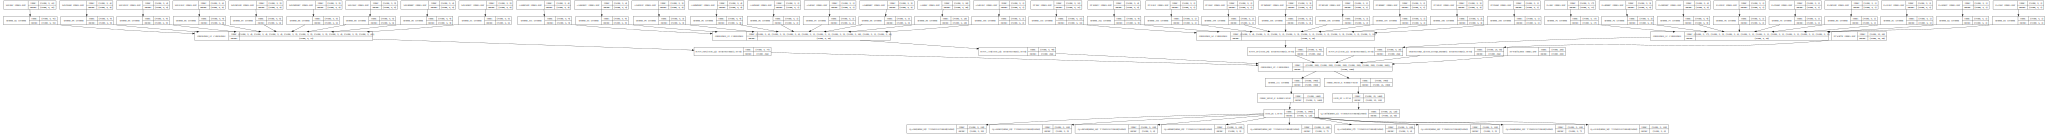

In [146]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
if not e.LOAD_MODEL:
    plot_model(model, to_file='plots/model_{}.png'.format(e.NAME), )#show_shapes=True)
SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

# 10. Training

In [52]:
# optional
e.set_name()

What is the name of this experiment? comp_end_stateful_test_.2018.09.04.16.32

NAME= comp_end_stateful_comp_end_stateful_test_.2018.09.04.16.32
DATE= .2018.09.05.15.18


In [147]:
if not e.LOAD_MODEL:
    earlyStopping=EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')

    tensorboard = TensorBoard(
        log_dir="logs/" + e.NAME + "_{}".format(e.thedate))


In [148]:
print(e.NAME + "_{}".format(e.thedate))


comp_end_stateful_diffwutf_.2018.09.06.16.33


In [149]:
if not e.LOAD_MODEL:
    history = model.fit(data['input'], data['output'],
                    batch_size=e.BATCH_SIZE,
                    shuffle=False,
                    callbacks=[earlyStopping, TestCallback(data['test']), tensorboard],
                    epochs=e.EPOCHS,
                    verbose=2,
                    sample_weight={i:((data["output"][i].argmax(axis=2) > 0).astype(int)*.9)+.1 for i in model.output_names},
                    validation_data=data['val'])

Train on 17905 samples, validate on 2226 samples
Epoch 1/40
 - 107s - loss: 2.8203 - QAutf8_loss: 1.1249 - QApos_loss: 0.4788 - QAaspect_loss: 0.1223 - QAperson_loss: 0.1748 - QAgender_loss: 0.1823 - QAnumber_loss: 0.1935 - QAcase_loss: 0.1851 - QAvoice_loss: 0.1123 - QAmood_loss: 0.1069 - QAstate_loss: 0.1394 - QAutf8_acc: 0.7145 - QApos_acc: 0.8628 - QAaspect_acc: 0.9150 - QAperson_acc: 0.9042 - QAgender_acc: 0.8985 - QAnumber_acc: 0.9086 - QAcase_acc: 0.9128 - QAvoice_acc: 0.9216 - QAmood_acc: 0.9074 - QAstate_acc: 0.9298 - val_loss: 5.1949 - val_QAutf8_loss: 0.8549 - val_QApos_loss: 1.0658 - val_QAaspect_loss: 0.2597 - val_QAperson_loss: 0.4051 - val_QAgender_loss: 0.4390 - val_QAnumber_loss: 0.5633 - val_QAcase_loss: 0.5999 - val_QAvoice_loss: 0.2476 - val_QAmood_loss: 0.3609 - val_QAstate_loss: 0.3988 - val_QAutf8_acc: 0.7633 - val_QApos_acc: 0.9155 - val_QAaspect_acc: 0.9760 - val_QAperson_acc: 0.9557 - val_QAgender_acc: 0.9529 - val_QAnumber_acc: 0.9397 - val_QAcase_acc: 0.9408

Epoch 9/40
 - 93s - loss: 0.7107 - QAutf8_loss: 0.3313 - QApos_loss: 0.0808 - QAaspect_loss: 0.0191 - QAperson_loss: 0.0363 - QAgender_loss: 0.0485 - QAnumber_loss: 0.0607 - QAcase_loss: 0.0437 - QAvoice_loss: 0.0330 - QAmood_loss: 0.0280 - QAstate_loss: 0.0294 - QAutf8_acc: 0.9097 - QApos_acc: 0.9725 - QAaspect_acc: 0.9910 - QAperson_acc: 0.9858 - QAgender_acc: 0.9825 - QAnumber_acc: 0.9783 - QAcase_acc: 0.9838 - QAvoice_acc: 0.9865 - QAmood_acc: 0.9881 - QAstate_acc: 0.9877 - val_loss: 2.8705 - val_QAutf8_loss: 0.3203 - val_QApos_loss: 0.3302 - val_QAaspect_loss: 0.1535 - val_QAperson_loss: 0.2144 - val_QAgender_loss: 0.3088 - val_QAnumber_loss: 0.4595 - val_QAcase_loss: 0.3328 - val_QAvoice_loss: 0.1674 - val_QAmood_loss: 0.3094 - val_QAstate_loss: 0.2741 - val_QAutf8_acc: 0.9178 - val_QApos_acc: 0.9677 - val_QAaspect_acc: 0.9837 - val_QAperson_acc: 0.9777 - val_QAgender_acc: 0.9721 - val_QAnumber_acc: 0.9602 - val_QAcase_acc: 0.9712 - val_QAvoice_acc: 0.9835 - val_QAmood_acc: 0.975

Epoch 17/40
 - 91s - loss: 0.3690 - QAutf8_loss: 0.1604 - QApos_loss: 0.0495 - QAaspect_loss: 0.0082 - QAperson_loss: 0.0151 - QAgender_loss: 0.0256 - QAnumber_loss: 0.0355 - QAcase_loss: 0.0234 - QAvoice_loss: 0.0174 - QAmood_loss: 0.0155 - QAstate_loss: 0.0183 - QAutf8_acc: 0.9564 - QApos_acc: 0.9824 - QAaspect_acc: 0.9968 - QAperson_acc: 0.9945 - QAgender_acc: 0.9913 - QAnumber_acc: 0.9882 - QAcase_acc: 0.9917 - QAvoice_acc: 0.9936 - QAmood_acc: 0.9941 - QAstate_acc: 0.9933 - val_loss: 2.8640 - val_QAutf8_loss: 0.2315 - val_QApos_loss: 0.3131 - val_QAaspect_loss: 0.1645 - val_QAperson_loss: 0.2114 - val_QAgender_loss: 0.3225 - val_QAnumber_loss: 0.4966 - val_QAcase_loss: 0.3281 - val_QAvoice_loss: 0.1730 - val_QAmood_loss: 0.3155 - val_QAstate_loss: 0.3077 - val_QAutf8_acc: 0.9461 - val_QApos_acc: 0.9699 - val_QAaspect_acc: 0.9861 - val_QAperson_acc: 0.9825 - val_QAgender_acc: 0.9743 - val_QAnumber_acc: 0.9631 - val_QAcase_acc: 0.9739 - val_QAvoice_acc: 0.9841 - val_QAmood_acc: 0.97

In [150]:
if not e.LOAD_MODEL:
    model.save("models/" + e.NAME + "_{}.keras".format(e.thedate))

## 11. Evaluate Trained Model

In [151]:
reduced_mapping = {"N": "NOUN","PN": "PROPN","ADJ": "ADJ","IMPN": "ADJ","PRP": "PRON","DEM": "PRON","REL": "PRON","PRON": "PRON","LOC": "ADV","T": "ADV","V": "VERB","P": "ADP","CONJ": "CCONJ","SUB": "SCONJ","ACC": "PART","AMD": "PART","ANS": "PART","AVR": "PART","CAUS": "PART","CERT": "PART","CIRC": "PART","COM": "PART","COND": "PART","EQ": "PART","EXH": "PART","EXL": "PART","EXP": "PART","FUT": "PART","INC": "PART","INT": "PART","INTG": "PART","NEG": "PART","PREV": "PART","PRO": "PART","REM": "PART","RES": "PART","RET": "PART","RSLT": "PART","SUP": "PART","SUR": "PART","VOC": "PART","INL": "PART","EMPH": "PART","IMPV": "PART","PRP": "PART","DET": "DET","INTJ": "INTJ","X": "X","SYM": "SYM","PUNC": "PUNCT","NUM": "NUM", "-1": "-1", "_": "_"}

In [155]:
def calc_accuracy(model,mydata,data_length, debug=True,train_vocab=[], reduced_mapping={}):
    preds = [np.argmax(x, axis=-1) for x in model.predict(mydata[0])]
    results = pd.DataFrame([], columns=[["inputs"]*3+["agg"]*3+model.output_names*3+["QAupos"]*3
                                        ,[e.strings_x[0],"index","OOV"]
                                        +["all","utf8","mf"]
                                        +["acc"]*len(model.output_names)
                                        +["pred"]*len(model.output_names)
                                        +["actu"]*len(model.output_names)
                                        + ["acc","pred","actu"]
                                       ])
    results.sort_index(axis=1, inplace=True)
    for ite in range(data_length):
        df2_row = mydata[2].iloc[ite*5]
        r = {
            ("inputs",e.strings_x[0]): ctable.decode(mydata[0][e.strings_x[0]][ite], calc_argmax=True).strip("+ "),
            ("inputs","index"): str(df2_row[("vals","sid")])+"-"+str(df2_row[("vals","aid")])+"-"+str(df2_row[("vals","wid")])+"-"+str(df2_row[("vals","mid")])
        }
        r[("inputs","OOV")] = r[("inputs",e.strings_x[0])] not in train_vocab
        for i, v in enumerate(model.output_names):
            if v not in e.strings_y:
                continue

            r[(v,"acc")] = (np.argmax(mydata[1][v][ite], axis=-1) == preds[i][ite]).all()
            r[(v,"pred")] = utf2bw(ctable.decode(preds[i][ite], calc_argmax=False)).strip(" ") if debug else ""
            r[(v,"actu")] = utf2bw(ctable.decode(mydata[1][v][ite], calc_argmax=True)).strip(" ") if debug else ""

        for i, v in enumerate(model.output_names):
            if v in e.strings_y:
                continue
            correct, pred = np.argmax(mydata[1][v][ite], axis=-1), preds[i][ite]
            r[(v,"acc")] = (correct == pred).all()
            r[(v,"actu")] = pretty_join2(correct,val[v].columns,v) if debug else ""
            r[(v,"pred")] = pretty_join2(pred,val[v].columns,v) if debug else ""
        if "QApos" in model.output_names:
            r[("QAupos","actu")] = "/".join([reduced_mapping[x] for x in r[("QApos","actu")].split("/")])
            r[("QAupos","pred")] = "/".join([reduced_mapping[x] for x in r[("QApos","pred")].split("/")])
            r[("QAupos","acc")] = r[("QAupos","actu")] == r[("QAupos","pred")]
            
        r[("agg","all")] = sum([r[(v,"acc")] for i, v in enumerate(model.output_names)]) == len(model.output_names)
        r[("agg","utf8")] = sum([r[(v,"acc")] for i, v in enumerate(model.output_names) if v != "QAutf8" ]) == len([x for i,v in enumerate(model.output_names) if v != "QAutf8"])
        r[("agg","mf")] = sum([r[(v,"acc")] for i, v in enumerate(model.output_names)  if v != "QAutf8" and v != "QApos" ]) == len([x for i,v in enumerate(model.output_names) if v != "QApos"])
        results.loc[ite] = r
    return results

In [157]:
result = calc_accuracy(model, [*data["test"],test], len(data["test"][0][e.strings_x[0]]),debug=True, 
                       train_vocab=set([x for x in train[(e.strings_x[0].replace("8",""),e.strings_x[0])].tolist() if type(x)==str]), reduced_mapping=reduced_mapping)

In [158]:
result.replace("(/-1)+", "", regex=True).replace(True, "").to_excel(e.writer,'results_test')
e.writer.save()

In [159]:
try:
    results
except NameError:
    results = {}

if e.NAME not in results:
    results[e.NAME] = {}

In [160]:
results[e.NAME]["results_test"]=result

In [161]:
r = {}
for x in list(accuracies.columns):
    if x in result.columns:
        r[x] = np.average(result[x].values.astype(int),axis=0)
    elif x[1] =="IOV_acc":
        r[x] = np.average(result[result[("inputs","OOV")]==False][(x[0],"acc")].values.astype(int),axis=0)
    elif x[1] =="OOV_acc":
        r[x] = np.average(result[result[("inputs","OOV")]==True][(x[0],"acc")].values.astype(int),axis=0)
    else:
        print(x)


accuracies.loc[e.NAME+"_test"] = r
accuracies.filter(regex="pos")


QApos            \
                                                         acc   IOV_acc   
comp_end_stateful_comp_end_stateful_test_.2018....  0.921384  0.934608   
comp_end_stateful_comp_end_stateful_test_.2018....  0.921384  0.000000   
comp_end_stateful_diffwutf_test                     0.883199  0.895238   

                                                                QAupos  \
                                                     OOV_acc       acc   
comp_end_stateful_comp_end_stateful_test_.2018....  0.885950  0.933064   
comp_end_stateful_comp_end_stateful_test_.2018....  0.000000  0.933064   
comp_end_stateful_diffwutf_test                     0.846154  0.898023   

                                                                        
                                                     IOV_acc   OOV_acc  
comp_end_stateful_comp_end_stateful_test_.2018....  0.946946  0.895868  
comp_end_stateful_comp_end_stateful_test_.2018....  0.000000  0.000000  
comp_end_stateful_diffwutf_test                     0.911905  0.855311

In [162]:
result_hadith = result[result[("inputs","index")].str.startswith("fourty")]
result_hadith.replace("(/-1)+", "", regex=True).replace(True, "").to_excel(e.writer,'results_hadith_test')
e.writer.save()

In [163]:
r = {}
for x in list(h_accuracies.columns):
    if x in result_hadith.columns:
        r[x] = np.average(result_hadith[x].values.astype(int),axis=0)
    elif x[1] =="IOV_acc":
        r[x] = np.average(result_hadith[result_hadith[("inputs","OOV")]==False][(x[0],"acc")].values.astype(int),axis=0)
    elif x[1] =="OOV_acc":
        r[x] = np.average(result_hadith[result_hadith[("inputs","OOV")]==True][(x[0],"acc")].values.astype(int),axis=0)
    else:
        print(x)


h_accuracies.loc[e.NAME+"_test"] = r
h_accuracies

QAaspect            \
                                                         acc   IOV_acc   
comp_end_stateful_comp_end_stateful_test_.2018....  0.930000  0.990276   
comp_end_stateful_diffwutf_test                     0.899329  0.990431   

                                                                QAcase  \
                                                     OOV_acc       acc   
comp_end_stateful_comp_end_stateful_test_.2018....  0.798587  0.811111   
comp_end_stateful_diffwutf_test                     0.685393  0.808725   

                                                                        \
                                                     IOV_acc   OOV_acc   
comp_end_stateful_comp_end_stateful_test_.2018....  0.875203  0.671378   
comp_end_stateful_diffwutf_test                     0.899522  0.595506   

                                                    QAgender            \
                                                         acc   IOV_acc   
comp_end_stateful_comp_end_stateful_test_.2018....  0.902222  0.969206   
comp_end_stateful_diffwutf_test                     0.869128  0.899522   

                                                                QAmood  \
                                                     OOV_acc       acc   
comp_end_stateful_comp_end_stateful_test_.2018....  0.756184  0.828889   
comp_end_stateful_diffwutf_test                     0.797753  0.825503   

                                                      ...      QAstate  \
                                                      ...      OOV_acc   
comp_end_stateful_comp_end_stateful_test_.2018....    ...     0.643110   
comp_end_stateful_diffwutf_test                       ...     0.629213   

                                                     QAvoice            \
                                                         acc   IOV_acc   
comp_end_stateful_comp_end_stateful_test_.2018....  0.951111  0.998379   
comp_end_stateful_diffwutf_test                     0.942953  0.990431   

                                                                QAutf8  \
                                                     OOV_acc       acc   
comp_end_stateful_comp_end_stateful_test_.2018....  0.848057  0.703333   
comp_end_stateful_diffwutf_test                     0.831461  0.510067   

                                                                       \
                                                     IOV_acc  OOV_acc   
comp_end_stateful_comp_end_stateful_test_.2018....  0.867099  0.34629   
comp_end_stateful_diffwutf_test                     0.703349  0.05618   

                                                         agg                 
                                                         all   mf      utf8  
comp_end_stateful_comp_end_stateful_test_.2018....  0.450000  0.0  0.490000  
comp_end_stateful_diffwutf_test                     0.362416  0.0  0.426174  

[2 rows x 36 columns]

In [164]:
result = calc_accuracy(model, [data["val"][0],data["val"][1],val], len(data["val"][0][e.strings_x[0]]),debug=True,
                       train_vocab=set([x for x in train[(e.strings_x[0].replace("8",""),e.strings_x[0])].tolist() if type(x)==str]), reduced_mapping=reduced_mapping)

In [165]:
result.replace("(/-1)+", "", regex=True).replace(True, "").to_excel(e.writer,'results_val')
e.writer.save()

In [166]:
result_hadith = result[result[("inputs","index")].str.startswith("fourty")]
result_hadith.replace("(/-1)+", "", regex=True).replace(True, "").to_excel(e.writer,'results_hadith_val')
e.writer.save()

In [167]:
results[e.NAME]["results_val"]=result

In [168]:
r = {x: np.average(result[x].values.astype(int),axis=0) 
     if x in result.columns else 0 for x in list(accuracies.columns)}

accuracies.loc[e.NAME+"_val"] = r
accuracies


QAaspect            \
                                                         acc   IOV_acc   
comp_end_stateful_comp_end_stateful_test_.2018....  0.965409  0.994448   
comp_end_stateful_comp_end_stateful_test_.2018....  0.965409  0.000000   
comp_end_stateful_diffwutf_test                     0.967206  0.992262   
comp_end_stateful_diffwutf_val                      0.938904  0.000000   

                                                                QAcase  \
                                                     OOV_acc       acc   
comp_end_stateful_comp_end_stateful_test_.2018....  0.887603  0.910602   
comp_end_stateful_comp_end_stateful_test_.2018....  0.000000  0.910602   
comp_end_stateful_diffwutf_test                     0.890110  0.946092   
comp_end_stateful_diffwutf_val                      0.000000  0.884097   

                                                                        \
                                                     IOV_acc   OOV_acc   
comp_end_stateful_comp_end_stateful_test_.2018....  0.942628  0.824793   
comp_end_stateful_comp_end_stateful_test_.2018....  0.000000  0.000000   
comp_end_stateful_diffwutf_test                     0.973810  0.860806   
comp_end_stateful_diffwutf_val                      0.000000  0.000000   

                                                    QAgender            \
                                                         acc   IOV_acc   
comp_end_stateful_comp_end_stateful_test_.2018....  0.936208  0.975324   
comp_end_stateful_comp_end_stateful_test_.2018....  0.936208  0.000000   
comp_end_stateful_diffwutf_test                     0.939353  0.964881   
comp_end_stateful_diffwutf_val                      0.891285  0.000000   

                                                                QAmood  \
                                                     OOV_acc       acc   
comp_end_stateful_comp_end_stateful_test_.2018....  0.831405  0.921833   
comp_end_stateful_comp_end_stateful_test_.2018....  0.000000  0.921833   
comp_end_stateful_diffwutf_test                     0.860806  0.943845   
comp_end_stateful_diffwutf_val                      0.000000  0.908805   

                                                      ...      QAstate  \
                                                      ...      OOV_acc   
comp_end_stateful_comp_end_stateful_test_.2018....    ...     0.801653   
comp_end_stateful_comp_end_stateful_test_.2018....    ...     0.000000   
comp_end_stateful_diffwutf_test                       ...     0.875458   
comp_end_stateful_diffwutf_val                        ...     0.000000   

                                                     QAvoice            \
                                                         acc   IOV_acc   
comp_end_stateful_comp_end_stateful_test_.2018....  0.963163  0.988896   
comp_end_stateful_comp_end_stateful_test_.2018....  0.963163  0.000000   
comp_end_stateful_diffwutf_test                     0.948787  0.979167   
comp_end_stateful_diffwutf_val                      0.930368  0.000000   

                                                                QAutf8  \
                                                     OOV_acc       acc   
comp_end_stateful_comp_end_stateful_test_.2018....  0.894215  0.774034   
comp_end_stateful_comp_end_stateful_test_.2018....  0.000000  0.774034   
comp_end_stateful_diffwutf_test                     0.855311  0.628931   
comp_end_stateful_diffwutf_val                      0.000000  0.620845   

                                                                        \
                                                     IOV_acc   OOV_acc   
comp_end_stateful_comp_end_stateful_test_.2018....  0.912400  0.403306   
comp_end_stateful_comp_end_stateful_test_.2018....  0.000000  0.000000   
comp_end_stateful_diffwutf_test                     0.804167  0.089744   
comp_end_stateful_diffwutf_val                      0.000000  0.000000   

                                               

In [ ]:
accuracies.to_excel(writer_all,'acc')
writer_all.save()

## 12. Charts

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history['val_loss'])
plt.plot(history.history['test_loss'])
plt.title('model overall loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val', 'test'], loc='upper right')
plt.savefig('plots/model_overall_loss' +
            e.NAME + "_{}".format(e.thedate) + '.png')
plt.close(fig)

# plt.show()


# In[471]:

# summarize history for loss
plt.plot(history.history["train_acc"])
plt.plot(history.history['val_acc'])
plt.plot(history.history['test_acc'])
plt.title('model average accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend([x +" = "+ str(round(history.history[x+'_acc'][-1]*100,2)) for x in ['train', 'val', 'test']], loc='lower right')
# for i, x in enumerate(['train', 'val', 'test']):
#     plt.annotate(str(round(history.history[x+'_acc'][-1]*100,2)),
#                  xy=(len(history.history[x+'_acc']), history.history[x+'_acc'][-1]), 
#                  textcoords='figure pixels', 
#                  xytext=(-20,-10))
plt.savefig('plots/model_average_accuracy' +
            e.NAME + "_{}".format(e.thedate) + '.png')


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(history.history["loss"])
plt.plot(history.history['val_loss'])
plt.plot(history.history['test_loss'])
plt.title('model overall loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val', 'test'], loc='upper right')
plt.savefig('plots/model_overall_loss' +
            e.NAME + "_{}".format(e.thedate) + '.png')

# plt.show()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(history.history["train_acc"])
plt.plot(history.history['val_acc'])
plt.plot(history.history['test_acc'])
plt.title('model average accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend([x +" = "+ str(round(history.history[x+'_acc'][-1]*100,2)) for x in ['train', 'val', 'test']], loc='lower right')
# for i, x in enumerate(['train', 'val', 'test']):
#     plt.annotate(str(round(history.history[x+'_acc'][-1]*100,2)),
#                  xy=(len(history.history[x+'_acc']), history.history[x+'_acc'][-1]), 
#                  textcoords='figure pixels', 
#                  xytext=(-20,-10))
plt.savefig('plots/model_average_accuracy' +
            e.NAME + "_{}".format(e.thedate) + '.png')

plt.show()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# VALIDATAION = True
# prefix = "val_" if VALIDATAION else ""
# del prefix
legends = []
for x in model.output_names:
    # summarize history for accuracy
    plt.plot(history.history[x+"_acc"])
    legends.append(""+x +" = "+ str(round(history.history[x+'_acc'][-1]*100,2)))
#     plt.plot(history.history[x+"_acc"])
#     legends.append("val_"+x)
#     plt.plot(history.history["val_" + x+"_acc"])
#     legends.append("train_"+x)
plt.title('model indiviual accuracy on test dataset')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(legends, loc='lower right')
plt.savefig('plots/accuracy_all' +
            e.NAME + "_{}".format(e.thedate) + '.png')
plt.show()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

legends = []
for x in model.output_names:
    # summarize history for loss
    plt.plot(history.history["test_"+x+"_loss"])
    legends.append(""+x +" = "+ str(round(history.history[x+'_loss'][-1]*100,2)))
plt.title('model individual loss on test dataset')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(legends, loc='upper right')
plt.savefig('plots/loss_all' +
            e.NAME + "_{}".format(e.thedate) + '.png')
plt.show()

## 10.1 Inspect One

In [ ]:
#%%capture --no-stderr cap
%autoreload 2

colors.ok = ''
colors.fail = ''
colors.close = ''


def inspectOne(times=0, printCorrect=True):
    isAllCorrect = True
    if times > 10000: # to prevent infinite loops
        return
    ind = np.random.randint(0, len(val.index))
    ind = (val.index[ind][0], slice(None))

    string_input = values_test.loc[(slice(None), ind[0]), :]
    preds = model.predict(
        getData(val.loc[ind], string_input, e.feat_x, e.strings_x))
    preds = [np.argmax(x, axis=-1) for x in preds]
    #predicted string
    print("Predicted String Q", string_input[e.strings_x[0]][0], "from",
          "-".join(str(x) for x in string_input.index.values[0]))

    if (np.argmax(string_input[e.strings_y[0]][0], axis=-1) == preds[0]).all():
        if printCorrect: print(colors.ok + '✅' + colors.close + "Segmentation")
    else:
        print(colors.fail + '❌' + colors.close + "Segmentation")
        isAllCorrect = False
        print("    T", utf2bw(string_input[e.strings_y[0]][0]))
        print("     ", utf2bw(ctable.decode(preds[0][0], calc_argmax=False)))


#     print('Q', utf2bw(pretty_join(rowx)))

    rowy = dict()
    for i, v in enumerate(e.feat_y):
        rowy[v] = {"correct": val[v].loc[ind]}
        res = np.zeros((SENTLEN, rowy[v]["correct"].shape[1]))
        for ii, c in enumerate(preds[i + 1][0]):
            res[ii, c] = 1
        rowy[v]["pred"] = pd.DataFrame(res, columns=val[v].columns)
        results = []
        if (rowy[v]["correct"].values == rowy[v]["pred"].values).all():
            if printCorrect: print(colors.ok + '✅' + colors.close + v)
        else:
            isAllCorrect = False
            print(colors.fail + '❌' + colors.close + v, end=' ')
            #             results.append(colors.fail + '☒' + colors.close)
            results.append('T ' + pretty_join(rowy[v]["correct"]))
            results.append(pretty_join(rowy[v]["pred"]))
            print(' '.join(results))
    if isAllCorrect or times < 10:
        print("")
        inspectOne(times + 1, printCorrect)

inspectOne(printCorrect=False)

with open(
        'output' + datetime.datetime.now().strftime(".%Y.%m.%d.%H.%M.%S") +
        '.txt', 'w') as f:
    f.write(cap.stdout)


### After alignment. Accuracy is good. Can be treated as baseline. (name=baseline)
`strings_cats_aligned_2018.06.25.15.14`
### Comaprison between baseline and POS embeddings. (No drop, so it is the best) (name=baseline+pos_emb)
`with_pos_embeddings_2018.06.25.17.37`
### Comaprison between baseline with POS embeddings and subword embeddings. (name=baseline+pos_emb+subword_emb)
`with_embeddings_2018.06.25.17.37` NOT DONE
### Comaprison between baseline with subword embeddings. (name=baseline+pos_emb+subword_emb+word2vec)
`with_word2vec_2018.06.25.17.37` NOT DONE

### Different Sizes of Baseline or subword